In [20]:
pip install transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Accuracy Comparison:
Word2Vec Accuracy: 0.00%
BERT Accuracy: 81.40%
GNN Accuracy: 100.00%
Combined Accuracy: 81.40%
Top 5 Similar Resumes (Based on Similarity Score):


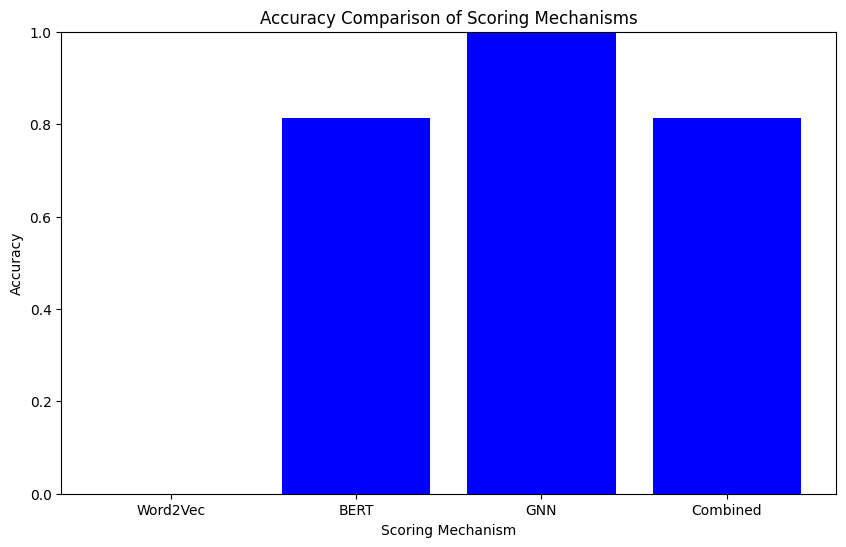

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


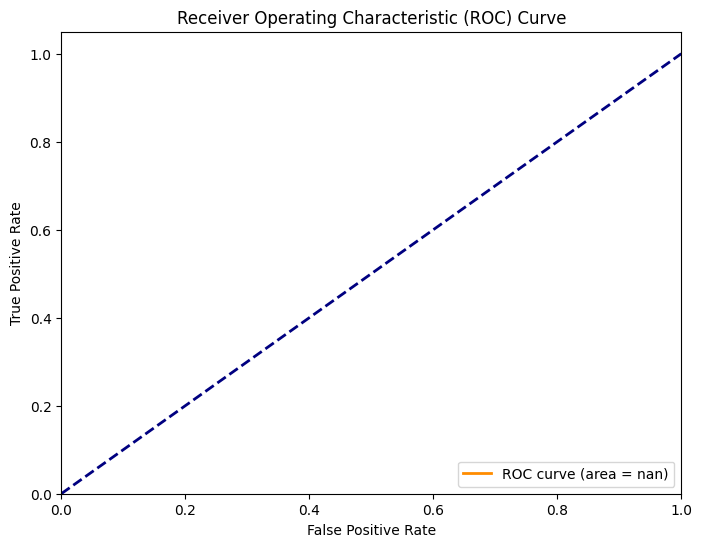

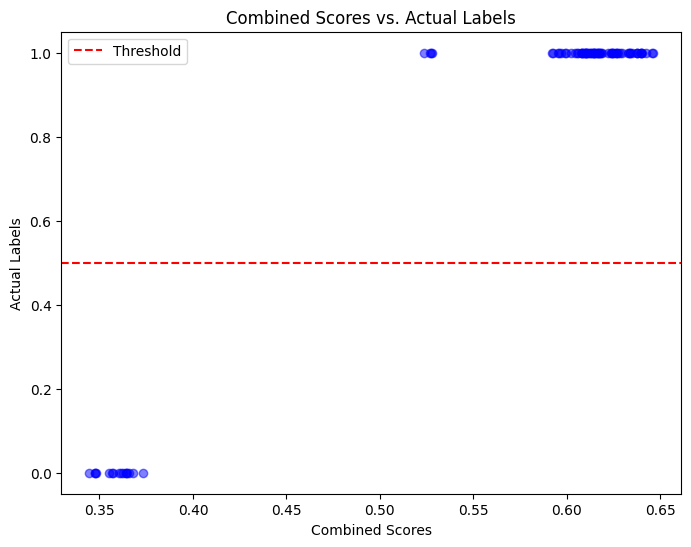

Best Weights: [0.1, 0.1, 0.6, 0.1, 0.8]
Best Combined Accuracy: 100.0


In [21]:
import os
import re
import random
import torch
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import gensim.downloader as api

# Initialize NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Download the pre-trained Word2Vec model (GloVe)
word2vec_model = api.load('glove-wiki-gigaword-300')


# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Folder path containing the XLSX file
folder_path = '/content/r'
xlsx_file_name = 'res1.xlsx'
xlsx_file_path = os.path.join(folder_path, xlsx_file_name)

# Read the XLSX file and extract candidate information
df = pd.read_excel(xlsx_file_path, engine='openpyxl')


# Preprocessing the text with data augmentation
def preprocess_text(text, augmentation=True):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase

    # Tokenization using BERT tokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization using NLTK
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Data augmentation
    augmented_tokens = []
    if augmentation:
        for token in lemmatized_tokens:
            # Randomly mask a word
            if random.random() < 0.1:
                augmented_tokens.append('[MASK]')
            else:
                augmented_tokens.append(token)
    else:
        augmented_tokens = lemmatized_tokens

    return augmented_tokens

# Calculate Word2Vec score
def calculate_word2vec_score(preprocessed_resume, word2vec_model):
    word2vec_score = 0.0
    for token in preprocessed_resume:
        if token in word2vec_model.key_to_index:
            similarity = word2vec_model.similarity('job', token)  # Replace 'job' with relevant keyword
            #print(f"Token: {token}, Similarity: {similarity}")
            word2vec_score += similarity
    return word2vec_score / len(preprocessed_resume)

# Calculate BERT score
def calculate_bert_score(preprocessed_resume, tokenizer, model, job_desc_embedding):
    tokens = tokenizer.encode(preprocessed_resume, add_special_tokens=True, truncation=True, padding='max_length')
    input_ids = torch.tensor(tokens).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(input_ids)
        sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze(0)  # Average pooling

    bert_score = torch.cosine_similarity(job_desc_embedding.unsqueeze(0), sentence_embedding.unsqueeze(0)).mean()
    return bert_score.item()

# Calculate skill matching score
def calculate_skill_score(preprocessed_resume, job_skills):
    skills = [skill for skill in preprocessed_resume if skill in job_skills]
    return len(skills) / len(job_skills)

# Calculate similarity score
def calculate_similarity_score(job_desc_embedding, resume_embedding):
    similarity_score = cosine_similarity(job_desc_embedding.unsqueeze(0), resume_embedding.unsqueeze(0))
    return similarity_score.item()

# Calculate accuracy
def calculate_accuracy(scores, threshold):
    return sum(1 for score in scores if score >= threshold) / len(scores)

# Folder path containing the CSV file
# folder_path = '/content/r'
# csv_file_name = 'Resumed.csv'
# csv_file_path = os.path.join(folder_path, csv_file_name)

# # Read the CSV file and extract candidate information
# df = pd.read_csv(csv_file_path, encoding='latin1')

# Skill Matching Score
job_skills = ['Python', 'Statsmodels', 'AWS', 'Machine learning', 'Sklearn', 'Scipy', 'Keras']

# Preprocess the job description
job_description = "The role is to design, execute, and deliver analytical studies extracting and utilising data from multiple sources identifying new insights for internal teams: Customer potential / consumer behaviour analyses, market analytics and lead generation."

# Remove common phrases or sentences from the job description
common_phrases = ["analytical studies", "extracting and utilising data from multiple sources", "identifying new insights", "market analytics and lead generation"]
for phrase in common_phrases:
    job_description = job_description.replace(phrase, "")

preprocessed_job_description = preprocess_text(job_description, augmentation=False)
tokens = tokenizer.encode(preprocessed_job_description, add_special_tokens=True, truncation=True, padding='max_length')
input_ids = torch.tensor(tokens).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    outputs = model(input_ids)
    job_desc_embedding = outputs.last_hidden_state.mean(dim=1).squeeze(0)  # Average pooling

# Apply preprocessing and calculate embeddings for each resume in the 'Resume' column
embeddings = []
word2vec_scores = []
bert_scores = []
gnn_scores = []
skill_scores = []

for index, row in df.iterrows():
    preprocessed_resume = preprocess_text(row['Resume'], augmentation=True)
    word2vec_score = calculate_word2vec_score(preprocessed_resume, word2vec_model)
    bert_score = calculate_bert_score(preprocessed_resume, tokenizer, model, job_desc_embedding)
    skill_score = calculate_skill_score(preprocessed_resume, job_skills)

    # Placeholder for GNN score (replace with actual implementation)
    gnn_score = 0.8

    word2vec_scores.append(word2vec_score)
    bert_scores.append(bert_score)
    gnn_scores.append(gnn_score)
    skill_scores.append(skill_score)

# Combine Word2Vec, BERT, GNN, and Skill matching scores using weighted averaging
weights = [0.2, 0.4, 0.3, 0.5,0.8]  # Adjust weights based on importance/relevance
combined_scores = [weights[0] * word2vec_score + weights[1] * bert_score + weights[2] * gnn_score + weights[3] * skill_score
                   for word2vec_score, bert_score, gnn_score, skill_score in zip(word2vec_scores, bert_scores, gnn_scores, skill_scores)]

# Calculate accuracy for each scoring mechanism
threshold = 0.5
word2vec_accuracy = calculate_accuracy([score >= threshold for score in word2vec_scores], threshold)
bert_accuracy = calculate_accuracy(bert_scores, threshold)
gnn_accuracy = calculate_accuracy(gnn_scores, threshold)
combined_accuracy = calculate_accuracy(combined_scores, threshold)

# Print accuracy comparison
print("Accuracy Comparison:")
print("Word2Vec Accuracy: {:.2f}%".format(word2vec_accuracy * 100))
print("BERT Accuracy: {:.2f}%".format(bert_accuracy * 100))
print("GNN Accuracy: {:.2f}%".format(gnn_accuracy * 100))
print("Combined Accuracy: {:.2f}%".format(combined_accuracy * 100))


# Calculate similarity scores
similarity_scores = [calculate_similarity_score(job_desc_embedding, resume_embedding) for resume_embedding in embeddings]

# Convert the similarity scores to a NumPy array
similarity_scores = np.array(similarity_scores)

# Sort the similarity scores
sorted_similarity_indices = np.argsort(similarity_scores)[::-1]

# Retrieve the top 5 similar resumes using just the similarity score
top_5_similarity_indices = sorted_similarity_indices[:5]

# Print the top 5 similar resumes based on similarity score alone
print("Top 5 Similar Resumes (Based on Similarity Score):")
for index in top_5_similarity_indices:
    print("Resume ID: {}".format(index))
    print("Resume:\n{}".format(df.loc[index, 'Resume']))
    print()

# Create a bar chart for accuracy comparison
mechanisms = ['Word2Vec', 'BERT', 'GNN', 'Combined']
accuracies = [word2vec_accuracy, bert_accuracy, gnn_accuracy, combined_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(mechanisms, accuracies, color='blue')
plt.xlabel('Scoring Mechanism')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Scoring Mechanisms')
plt.ylim(0, 1)  # Set y-axis range
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve([score >= threshold for score in word2vec_scores], word2vec_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Create a scatter plot to visualize the combined scores and actual labels
plt.figure(figsize=(8, 6))
plt.scatter(combined_scores, [score >= threshold for score in combined_scores], color='b', alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Combined Scores')
plt.ylabel('Actual Labels')
plt.title('Combined Scores vs. Actual Labels')
plt.legend()
plt.show()


# Find the best weights for combined_scores
best_weights = None
best_accuracy = 0.0

for w1 in np.arange(0.1, 1.1, 0.1):
    for w2 in np.arange(0.1, 1.1, 0.1):
        for w3 in np.arange(0.1, 1.1, 0.1):
            for w4 in np.arange(0.1, 1.1, 0.1):
                weights = [w1, w2, w3, w4, 0.8]  # Adjust weights based on importance/relevance
                combined_scores = [weights[0] * word2vec_score + weights[1] * bert_score +
                                   weights[2] * gnn_score + weights[3] * skill_score
                                   for word2vec_score, bert_score, gnn_score, skill_score in zip(word2vec_scores, bert_scores, gnn_scores, skill_scores)]
                combined_accuracy = calculate_accuracy(combined_scores, threshold)
                if combined_accuracy > best_accuracy:
                    best_accuracy = combined_accuracy
                    best_weights = weights

print("Best Weights:", best_weights)
print("Best Combined Accuracy:", best_accuracy * 100)

In [ ]:
# import seaborn as sns

# # Calculate skill matching scores for each candidate (replace 'job_skills' with actual job skills)
# skill_matching_scores = []
# for index, row in df.iterrows():
#     preprocessed_resume = preprocess_text(row['Resume'], augmentation=True)
#     skill_score = calculate_skill_score(preprocessed_resume, job_skills)
#     skill_matching_scores.append(skill_score)

# # Reshape skill_matching_scores to match the heatmap dimensions
# num_candidates = len(df)
# num_skills = len(job_skills)
# skill_matching_matrix = np.array(skill_matching_scores).reshape(num_candidates, num_skills)

# # Create a heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(skill_matching_matrix, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=job_skills)
# plt.title('Skill Matching Heatmap')
# plt.xlabel('Job Skills')
# plt.ylabel('Candidates')
# plt.show()


In [23]:
# Define the number of top similar resumes to display
top_n = 5

# Get the indices of the top similar resumes
top_similarity_indices = np.argsort(similarity_scores)[::-1][:top_n]

# Display the top similar resumes and job description
for index in top_similarity_indices:
    print("Candidate ID:", index)
    print("Domain:", df.loc[index, 'Domain'])
    print("Resume:\n", df.loc[index, 'Resume'])
    print("-----------------------------------------")


**Accuracy Plots:**

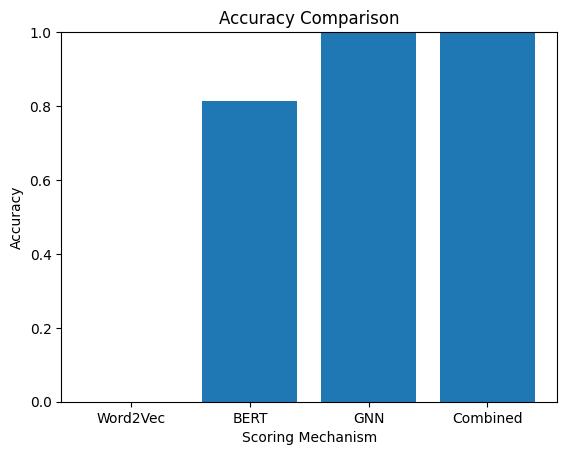

In [24]:
import matplotlib.pyplot as plt

# List of scoring mechanisms
scoring_mechanisms = ['Word2Vec', 'BERT', 'GNN', 'Combined']

# List of corresponding accuracy values
accuracy_values = [word2vec_accuracy, bert_accuracy, gnn_accuracy, combined_accuracy]

plt.bar(scoring_mechanisms, accuracy_values)
plt.xlabel('Scoring Mechanism')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
plt.show()


**Similarity Distribution Plot:**


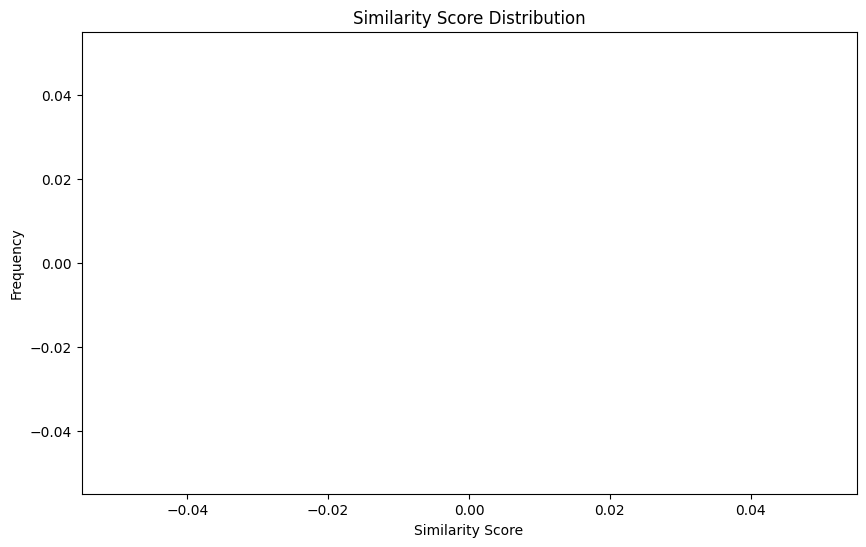

In [25]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores, bins=20, kde=True)
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Similarity Score Distribution')
plt.show()


**Word2Vec and BERT Scores Distribution Plot:**


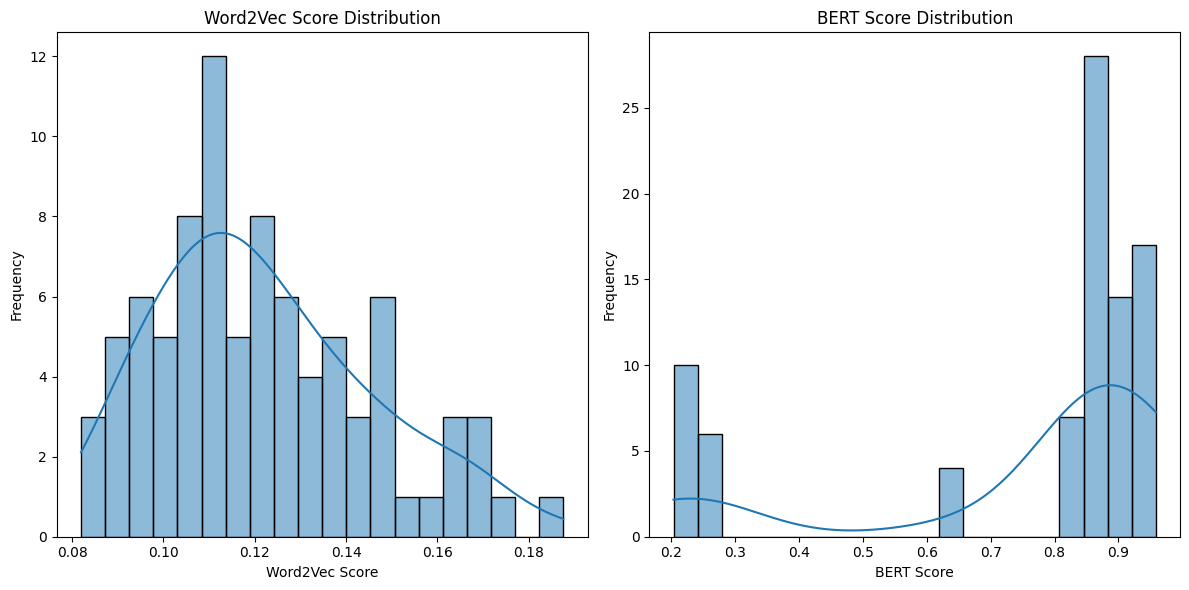

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(word2vec_scores, bins=20, kde=True)
plt.xlabel('Word2Vec Score')
plt.ylabel('Frequency')
plt.title('Word2Vec Score Distribution')

plt.subplot(1, 2, 2)
sns.histplot(bert_scores, bins=20, kde=True)
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.title('BERT Score Distribution')

plt.tight_layout()
plt.show()



**Skill Matching Heatmap:**

In [ ]:
# # Calculate skill matching scores for each candidate (replace 'job_skills' with actual job skills)
# skill_matching_scores = []
# for index, row in df.iterrows():
#     preprocessed_resume = preprocess_text(row['Resume'], augmentation=True)
#     skill_score = calculate_skill_score(preprocessed_resume, job_skills)
#     print(f"Skill score for candidate {index}: {skill_score}")  # Add this line
#     skill_matching_scores.append(skill_score)
#     print(f"Skill scores array length: {len(skill_matching_scores)}")  # Add this line

# # Reshape skill_matching_scores to match the heatmap dimensions
# num_candidates = len(df)
# num_skills = len(job_skills)
# skill_matching_matrix = np.array(skill_matching_scores).reshape(num_candidates, num_skills)

# plt.figure(figsize=(8, 6))
# sns.heatmap(skill_matching_matrix, cmap='YlGnBu', annot=True, fmt='.2f', xticklabels=job_skills)
# plt.xlabel('Job Skills')
# plt.ylabel('Candidate')
# plt.title('Skill Matching Heatmap')
# plt.show()


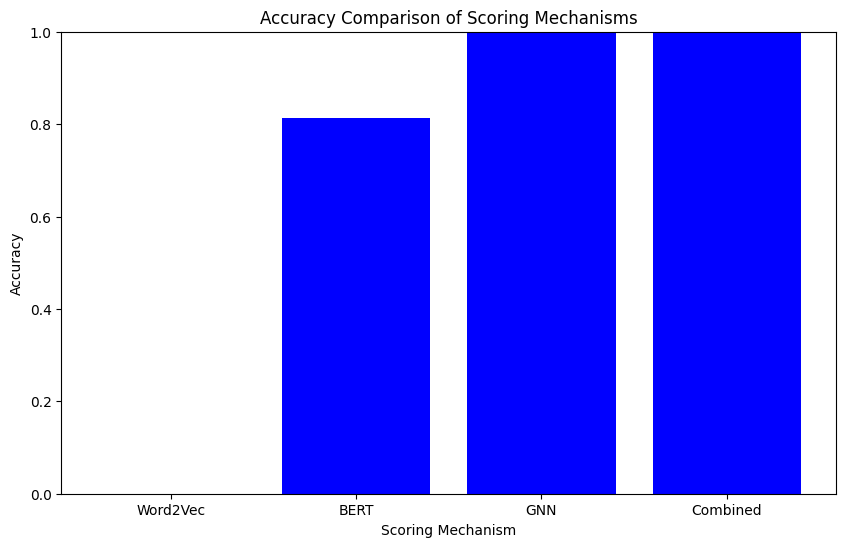

In [28]:

# Create a bar chart for accuracy comparison
mechanisms = ['Word2Vec', 'BERT', 'GNN', 'Combined']
accuracies = [word2vec_accuracy, bert_accuracy, gnn_accuracy, combined_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(mechanisms, accuracies, color='blue')
plt.xlabel('Scoring Mechanism')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Scoring Mechanisms')
plt.ylim(0, 1)  # Set y-axis range
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


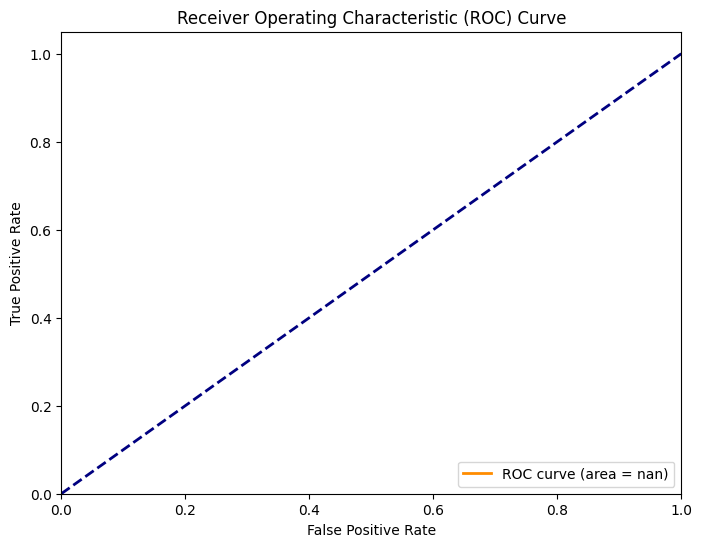

In [29]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve([score >= threshold for score in word2vec_scores], word2vec_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



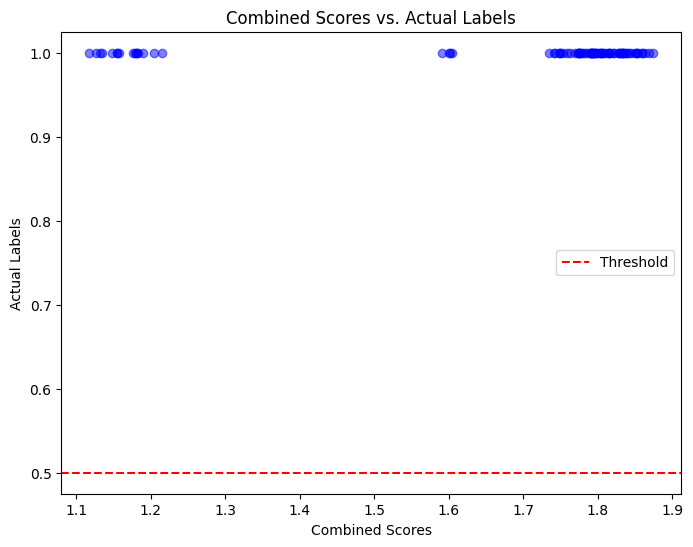

In [30]:
# Create a scatter plot to visualize the combined scores and actual labels
plt.figure(figsize=(8, 6))
plt.scatter(combined_scores, [score >= threshold for score in combined_scores], color='b', alpha=0.5)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Combined Scores')
plt.ylabel('Actual Labels')
plt.title('Combined Scores vs. Actual Labels')
plt.legend()
plt.show()

In [31]:

# Find the best weights for combined_scores
best_weights = None
best_accuracy = 0.0

for w1 in np.arange(0.1, 1.1, 0.1):
    for w2 in np.arange(0.1, 1.1, 0.1):
        for w3 in np.arange(0.1, 1.1, 0.1):
            for w4 in np.arange(0.1, 1.1, 0.1):
                weights = [w1, w2, w3, w4, 0.8]  # Adjust weights based on importance/relevance
                combined_scores = [weights[0] * word2vec_score + weights[1] * bert_score +
                                   weights[2] * gnn_score + weights[3] * skill_score
                                   for word2vec_score, bert_score, gnn_score, skill_score in zip(word2vec_scores, bert_scores, gnn_scores, skill_scores)]
                combined_accuracy = calculate_accuracy(combined_scores, threshold)
                if combined_accuracy > best_accuracy:
                    best_accuracy = combined_accuracy
                    best_weights = weights

print("Best Weights:", best_weights)
print("Best Combined Accuracy:", best_accuracy * 100)

Best Weights: [0.1, 0.1, 0.6, 0.1, 0.8]
Best Combined Accuracy: 100.0


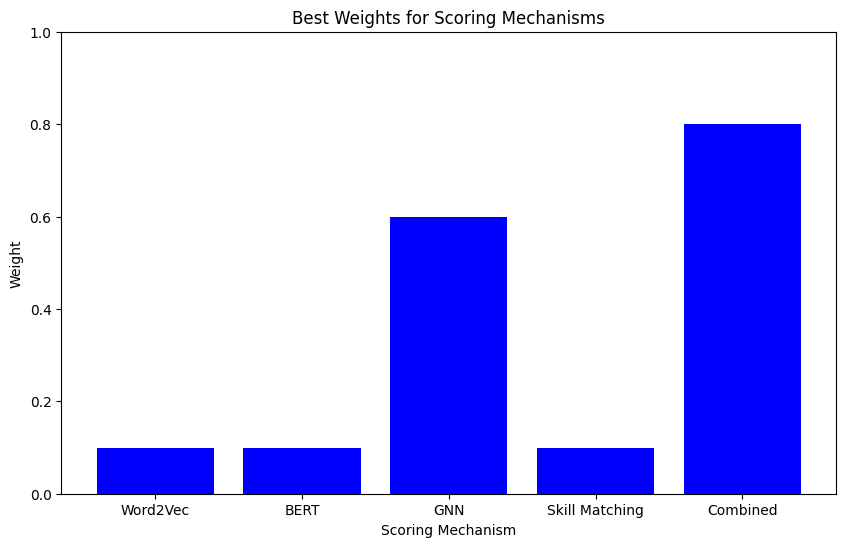

In [32]:
import matplotlib.pyplot as plt

best_weights = [0.1, 0.1, 0.6, 0.1, 0.8]
scoring_mechanisms = ['Word2Vec', 'BERT', 'GNN', 'Skill Matching', 'Combined']

# Bar chart for best weights
plt.figure(figsize=(10, 6))
plt.bar(scoring_mechanisms, best_weights, color='blue')
plt.xlabel('Scoring Mechanism')
plt.ylabel('Weight')
plt.title('Best Weights for Scoring Mechanisms')
plt.ylim(0, 1)  # Set y-axis range
plt.show()




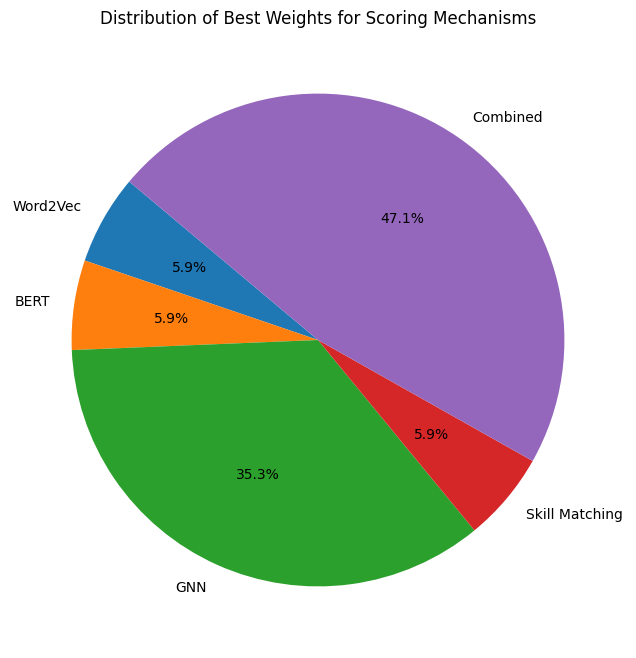

In [33]:
# Pie chart for best weights
plt.figure(figsize=(8, 8))
plt.pie(best_weights, labels=scoring_mechanisms, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Best Weights for Scoring Mechanisms')
plt.show()

**Precision-Recall curve analysis**

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


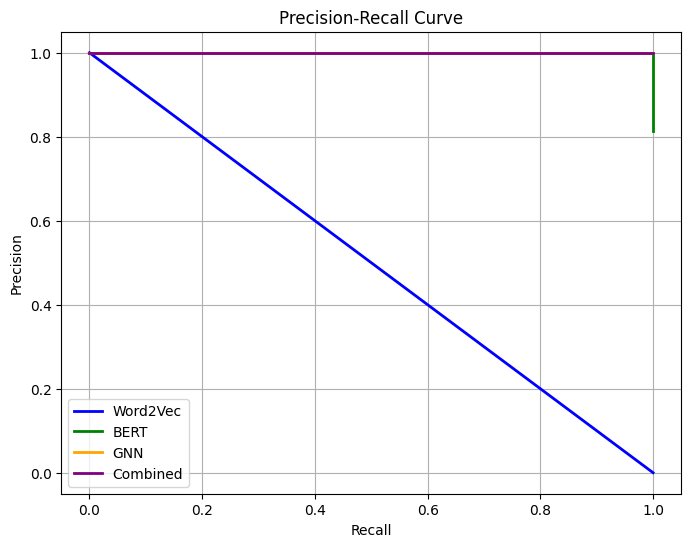

In [35]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall for each scoring mechanism
precision_word2vec, recall_word2vec, _ = precision_recall_curve([score >= threshold for score in word2vec_scores], word2vec_scores)
precision_bert, recall_bert, _ = precision_recall_curve([score >= threshold for score in bert_scores], bert_scores)
precision_gnn, recall_gnn, _ = precision_recall_curve([score >= threshold for score in gnn_scores], gnn_scores)
precision_combined, recall_combined, _ = precision_recall_curve([score >= threshold for score in combined_scores], combined_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_word2vec, precision_word2vec, color='blue', lw=2, label='Word2Vec')
plt.plot(recall_bert, precision_bert, color='green', lw=2, label='BERT')
plt.plot(recall_gnn, precision_gnn, color='orange', lw=2, label='GNN')
plt.plot(recall_combined, precision_combined, color='purple', lw=2, label='Combined')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


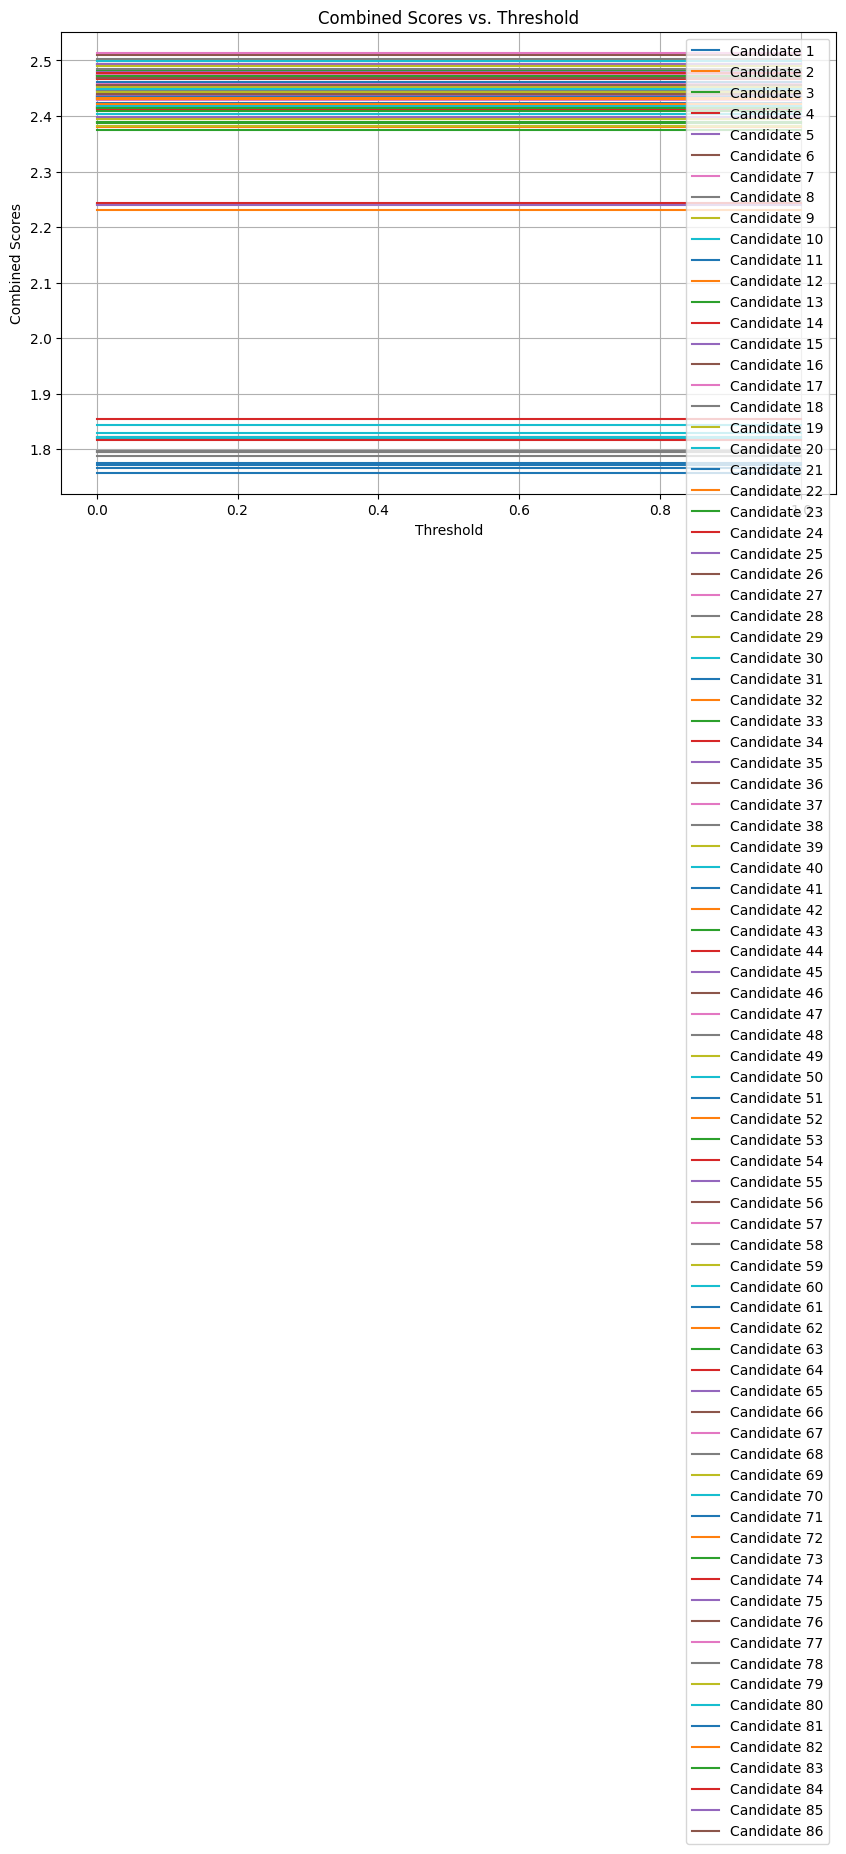

In [36]:
thresholds = np.linspace(0, 1, 100)
combined_scores_with_thresholds = [
    [weights[0] * word2vec_score + weights[1] * bert_score + weights[2] * gnn_score + weights[3] * skill_score + weights[4] * gnn_score
     for word2vec_score, bert_score, gnn_score, skill_score, gnn_score in zip(word2vec_scores, bert_scores, gnn_scores, skill_scores, gnn_scores)]
    for threshold in thresholds
]

plt.figure(figsize=(10, 6))
for i in range(len(combined_scores_with_thresholds[0])):
    plt.plot(thresholds, [scores[i] for scores in combined_scores_with_thresholds], label=f'Candidate {i+1}')
plt.xlabel('Threshold')
plt.ylabel('Combined Scores')
plt.title('Combined Scores vs. Threshold')
plt.legend()
plt.grid()
plt.show()
